In [1]:
#!conda install -y -c anaconda pillow
#!conda install -y -c conda-forge ipywidgets

# Ejercicio 2.1

In [139]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests
from io import BytesIO

In [140]:
import warnings
warnings.simplefilter('ignore')

In [141]:
%matplotlib inline
plt.style.use('classic')



In [142]:
def load_image(img):
    imgmat_array = np.array(list(img.getdata()), float)
    imgmat_array = imgmat_array / 255
    imgmat = imgmat_array
    imgmat.shape = (img.size[1], img.size[0] , 3 )
    return (imgmat , imgmat_array)


def load_image_from_disk (image_path):
    img = Image.open(image_path)
    return load_image(img)

def load_image_from_url(image_url):
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))
    return load_image(img)


def display_image (imgmat):
    plt.figure(figsize=(9, 6))
    #plt.imshow((imgmat * 255).astype(np.uint8))
    plt.imshow(imgmat)
    plt.show()

In [143]:
img_url = "https://users.cs.cf.ac.uk/Dave.Marshall/Multimedia/parrots.jpeg"
imgmat , imgmat_array = load_image_from_url(img_url)


# Desde disco local
# imgmat , imgmat_array = load_image_from_disk('images/parrot.jpg')


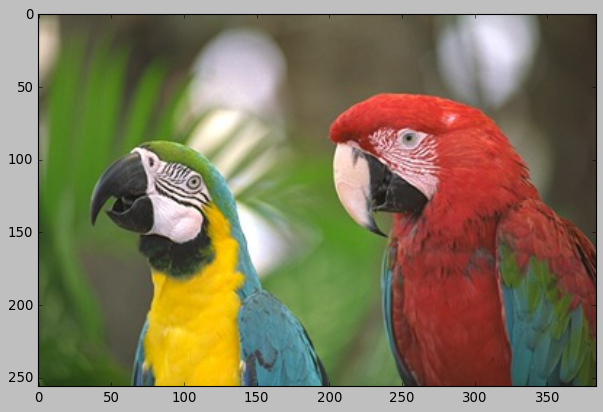

In [144]:
display_image (imgmat)

In [336]:
def generate_yiq_from_rgb(imgmat_array):
    
    yiq_from_rgb_extended = np.array([[0.299,      0.587,        0.114],
                        [0.59590059, -0.27455667, -0.32134392],
                        [0.21153661, -0.52273617, 0.31119955]])
    
    yiq_from_rgb = np.array([[0.299,      0.587,        0.114],
                        [0.595716, -0.274453, -0.321263],
                        [0.211456, -0.522591, 0.311135]])
    
    
    
    result =  np.dot(imgmat_array, yiq_from_rgb.T.copy())
    return result



def generate_rgb_from_yiq(imgmat_array , alpha , beta):
    yiq_from_rgb = np.array([[1 * alpha, 0.9663 * beta, 0.6210 * beta],
                             [1 * alpha , -0.2721 * beta, -0.6474 * beta],
                             [1 * alpha, -1.1070 * beta, 1.7046* beta] ])
    result =  np.dot(imgmat_array, yiq_from_rgb.T.copy())
    return result



def iq_strategy_coerce(i,q, beta, i_original, q_original ):

    i_max = 0.5957
    i_min = i_max * -1
    
    q_max = 0.5226
    q_min = q_max * -1

    q_diff = 0
    
    i_coerced = i
    q_coerced = q
    
    if abs(i) > i_max:
        i_coerced = i_min  if i < 0 else i_max
        
    
    if abs(q) > q_max:
        q_coerced = q_min  if i < 0 else q_max

        
    return (i_coerced , q_coerced)



def modidify_yiq (imgmat_array , alpha , beta , iq_strategy):
  
    generated_array = np.empty(shape = imgmat_array.shape )
    
    for xc_index, xc in enumerate(imgmat_array):
        for yc_index, yc in enumerate(xc):
            y = alpha * yc[0]
            i = beta * yc[1]
            q = beta * yc[2]
           
            if y > 1:
                y = 1
            
            
            (i,q) = iq_strategy(i,q, beta, yc[1], yc[2])
            
            generated_array[xc_index, yc_index, 0 ] = y
            generated_array[xc_index, yc_index, 1 ] = i
            generated_array[xc_index, yc_index, 2 ] = q
    
    return generated_array;
    
    
def generate_rgb_from_yiq_control(imgmat_array ):
    rgb_from_yiq = np.array([[1 , 0.9663 , 0.6210 ],
                             [1  , -0.2721 , -0.6474 ],
                             [1 , -1.1070 , 1.7046] ])
    
   
    result =  np.dot(imgmat_array, rgb_from_yiq.T.copy())
    
    return result 






In [452]:
class UnAcceptedValueError(Exception):   
    def __init__(self, data):    
        self.data = data
    def __str__(self):
        return repr(self.data)
    
    
class Square_Kernel:
    def __init__(self, matrix):
       
        self.matrix = matrix
        
        self.check_kernel()
       
        
    def check_kernel(self):
        if (self.matrix.shape[0] != self.matrix.shape[1]):
             raise UnAcceptedValueError("El kernel debe ser cuadrado")
            
        if (self.matrix.shape[0] % 2 == 0):
            raise UnAcceptedValueError("La cantidad de filas y columnas debe ser impar")

    def get_centroid(self):
    
        x = int(self.matrix.shape[0]/2)
        y = x
        return (x,y)
    
    def get_shape(self):
        return (self.matrix.shape)
    
    def calculate_product_sum(self, matrix_b):
        
        result = 0 
        if ((matrix_b.shape[0] != self.matrix.shape[0] ) or (matrix_b.shape[1] != self.matrix.shape[1])):
            raise UnAcceptedValueError(f"Las matrices a procesar deben tener misma cantidad de filas y columnas. Matriz a{self.matrix.shape} Matris b{matrix_b.shape}")

        
        for xc_index, xc in enumerate(self.matrix):
            for yc_index, yc in enumerate(xc):
                
                result = result + (yc * matrix_b[xc_index][yc_index])
                #print (result)
        
        return result

class Image_Matrix:
    
    #La imagen debe ser YIQ (imgmat_array)
    def __init__(self, imgmat_array , kernel ):

        self.imgmat_array = imgmat_array
        self.kernel = kernel
        self.expanded_matrix = None
        
        
   
    #Método privado. Toma el kernel y en base a ello le agrega filas y columnas
    #a la imagen. Le agrega tantas filas y columnas de manera tal que el kernel pueda
    # ir elemento x elemento de la imagen original y siempre tenga valores para tomar de la 
    # imagen
    def _expand_matrix (self): 
    
        factor = 2
        kernel_centroid = self.kernel.get_centroid()
        centroide = kernel_centroid[0]
        
        
        print (f"Kernel centroid {centroide}")
        A = self.imgmat_array[:,:,0]
        print (f" Shape A {A.shape}")
        
        A_1 =np.zeros((A.shape[0] + factor * centroide  ,A.shape[1] ))
        print (f" Shape A_1 {A_1.shape}")
    
        A_1[centroide:-centroide, :] =A 
        A_1[0:centroide,:] = A[0]
        A_1[-centroide:,:] = A[A.shape[0]-1]

       
        
        A_2 =np.zeros((A_1.shape[0] ,A_1.shape[1] + factor * centroide ))
        print (f" Shape A_2 {A_2.shape}")
            
       
        
        A_2[:, centroide:-centroide] =A_1 
        A_2[:,0:centroide] = A_1[:,0:1]
        A_2[:,-centroide:] = A_1[:,A_1.shape[1]-1:]
        
        #Se puede calcular una vez y luego reutilizar n veces en el apply_filter
        self.expanded_matrix = A_2
        
        return A_2


    #Saca de la imagen, la matriz a la cual se le tiene que hacer la operación punto con el kernel
    def _get_sub_matrix(self, row, col):
        
        kernel_shape = self.kernel.get_shape()
        kernel_centroid = self.kernel.get_centroid()
        
        
        print(f"Se crea la sub matrix con shape {kernel_shape}")
        sub_matrix =np.zeros(kernel_shape)
        print(f"Kernel centroide {kernel_centroid}")
        start_row = row - kernel_centroid[0]
        end_row = row +  kernel_centroid[0] + 1
        
        start_col = col - kernel_centroid[1]
        end_col = col + kernel_centroid[1] + 1
        
        print(f" Se extra de imgmat las filas: {start_row} - {end_row}")
        print(f" Se extrae de imgmat las columnas: {start_col} - {end_col}")
        sub_matrix = self.imgmat_array[start_row: end_row ,start_col: end_col ][0]
       
        print (sub_matrix)
        
        return sub_matrix
                             
        
    def apply_filter_yiq (self):

        #Se puede optimizar usando self.expanded_matrix en vez de calcular a cada rato la 
        #matriz expandida
        expanded_image = self._expand_matrix()
        
        filtered_image = np.empty(shape = self.imgmat_array.shape )

        kernel_centroid = self.kernel.get_centroid()

        row_start_index = kernel_centroid[0]
        row_end_index = self.imgmat_array.shape[0] - 1
        col_start_index = kernel_centroid[1]
        col_end_index = self.imgmat_array.shape[1] - 1
        
        
        print (f"Rango row: {row_start_index} - {row_end_index} , col: {col_start_index} - {col_end_index}")
        
       
        for row in range(row_start_index, row_end_index):
            #print (f"fila {row}")
            for col in range(col_start_index,col_end_index ):
                #print (f"columna {col}")
                print (self.imgmat_array[row,col,0])
                sub_matrix = self._get_sub_matrix(row, col)
                
                filtered_image[row - 1 , col - 1] = self.kernel.calculate_product_sum(sub_matrix)
                             
                
        return None;

In [453]:
result = generate_yiq_from_rgb(imgmat_array)

In [454]:
A = np.full((5, 5), 1/25)

In [455]:
kernel = Square_Kernel(A)
print (f"{kernel.get_shape()}")
result_test = kernel.calculate_product_sum(A)
print (f"Suma de los productos {result_test}")

(5, 5)
Suma de los productos 0.039999999999999994


In [456]:
image_matrix = Image_Matrix(imgmat_array, kernel)
#result_aux = image_matrix.apply_filter_yiq()
result_coviedo = image_matrix._expand_matrix()

Kernel centroid 2
 Shape A (256, 384)
 Shape A_1 (260, 384)
 Shape A_2 (260, 388)


In [457]:
result_coviedo[:, -4:]

array([[0.19215686, 0.18823529, 0.18823529, 0.18823529],
       [0.19215686, 0.18823529, 0.18823529, 0.18823529],
       [0.19215686, 0.18823529, 0.18823529, 0.18823529],
       ...,
       [0.23137255, 0.20392157, 0.20392157, 0.20392157],
       [0.23137255, 0.20392157, 0.20392157, 0.20392157],
       [0.23137255, 0.20392157, 0.20392157, 0.20392157]])

In [458]:
result_coviedo.shape

result_coviedo_2 = np.zeros(shape = (result_coviedo.shape[0] , result_coviedo.shape[1], 3) )

result_coviedo_2.shape

(260, 388, 3)

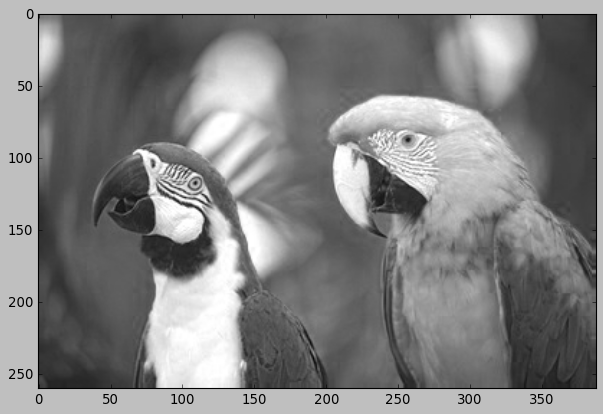

(260, 388, 3)


In [459]:
result_coviedo_2[:,:,0] = result_coviedo

result_coviedo_3 = generate_rgb_from_yiq_control(result_coviedo_2)
display_image (result_coviedo_3)
print(result_coviedo_3.shape)

# Pongo i, q = 0 para quedarme con la imagen en escalas de grises

In [460]:
image_matrix.apply_filter_yiq()

Kernel centroid 2
 Shape A (256, 384)
 Shape A_1 (260, 384)
 Shape A_2 (260, 388)
Rango row: 2 - 255 , col: 2 - 383
0.5411764705882353
Se crea la sub matrix con shape (5, 5)
Kernel centroide (2, 2)
 Se extra de imgmat las filas: 0 - 5
 Se extrae de imgmat las columnas: 0 - 5
[[0.47058824 0.45098039 0.3372549 ]
 [0.47058824 0.45490196 0.34117647]
 [0.48235294 0.46666667 0.35294118]
 [0.48627451 0.47058824 0.35686275]
 [0.47843137 0.4627451  0.34901961]]


UnAcceptedValueError: 'Las matrices a procesar deben tener misma cantidad de filas y columnas. Matriz a(5, 5) Matris b(5, 3)'

# Filtro plano -  3 x 3

In [325]:
A = np.full((3, 3), 1/9)
A

array([[0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111]])

In [326]:
result_1[1][1][0]

0.4713294117647059

In [327]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
#https://stackoverflow.com/questions/36351109/ipython-notebook-ipywidgets-does-not-show

In [328]:
def modify_image(lumenance, chrome , imgmat_array ,imgmat ):
    
    result = generate_yiq_from_rgb(imgmat_array)
    result_1 = generate_rgb_from_yiq_control(result , lumenance ,chrome , iq_strategy_coerce)
    result_1.shape = imgmat.shape
    display_image (result_1)
    
def modify_image_2(lumenance, chrome):
    modify_image( lumenance /100, chrome / 100 ,imgmat_array = imgmat_array , imgmat  = imgmat)

In [32]:
interact(modify_image_2, lumenance=widgets.IntSlider(min=1, max=200, step=1, value=100) , chrome =widgets.IntSlider(min=1, max=200, step=1, value=100) );

interactive(children=(IntSlider(value=100, description='lumenance', max=200, min=1), IntSlider(value=100, desc…

## Ejercicio 1.2

In [ ]:
import math

def generate_rgb_from_yiq_lumenance(imgmat_array , transformation):
    rgb_from_yiq = np.array([[1 , 0.9663 , 0.6210 ],
                             [1  , -0.2721 , -0.6474 ],
                             [1 , -1.1070 , 1.7046] ])
    
    generated_array = np.empty(shape = imgmat_array.shape )
    
    for xc_index, xc in enumerate(imgmat_array):
        for yc_index, yc in enumerate(xc):
            y = transformation(yc[0])
            i = yc[1]
            q = yc[2]
           
            generated_array[xc_index, yc_index, 0 ] = y
            generated_array[xc_index, yc_index, 1 ] = i
            generated_array[xc_index, yc_index, 2 ] = q
    
    result =  np.dot(generated_array, rgb_from_yiq.T.copy())
         
    return result


In [ ]:
def sqr_transformation(value):
    return math.sqrt(value)

def pow_transformation (value):
    return value * value

def null_transformation(value):
    return value

In [ ]:
display_image (imgmat)

In [ ]:
result = generate_yiq_from_rgb(imgmat_array)
result_1 = generate_rgb_from_yiq_lumenance(result,sqr_transformation )

In [ ]:
display_image (result_1)

In [ ]:
result_1 = generate_rgb_from_yiq_lumenance(result,pow_transformation )

In [ ]:
display_image (result_1)

In [ ]:
    

    
def modify_image_lumenance_2(strategy):
    
    result = generate_yiq_from_rgb(imgmat_array)
    
    strategy_method = sqr_transformation
    
    
    if strategy == "sqrt":
        strategy_method = sqr_transformation
    elif strategy == "pow":
        strategy_method = pow_transformation
    else: 
        strategy_method = null_transformation
    
    
    result_1 = generate_rgb_from_yiq_lumenance(result,strategy_method )
    result_1.shape = imgmat.shape
    display_image (result_1)

    
drop_down = widgets.Dropdown(
    options=['normal', 'sqrt', 'pow'],
    value='normal',
    description='Filtro:',
    disabled=False,
)    

interact(modify_image_lumenance_2, strategy=drop_down );

In [ ]:
def generate_rgb_from_yiq_lumenance_linea_segmentos(imgmat_array , lower_x, upper_x):
    rgb_from_yiq = np.array([[1 , 0.9663 , 0.6210 ],
                             [1  , -0.2721 , -0.6474 ],
                             [1 , -1.1070 , 1.7046] ])
    
    
    # Referencia
    # m = ( y2 - y1) / (x2 - x1)
    # y - y1 = m (x - x1)
    
    pendiente = 1 / (upper_x - lower_x)
    
   
    
    
    generated_array = np.empty(shape = imgmat_array.shape )
    
    for xc_index, xc in enumerate(imgmat_array):
        for yc_index, yc in enumerate(xc):
            
            if yc[0] < lower_x:
                y = 0
            elif yc[0] > upper_x:
                y = 1
            else:
                y = (pendiente * ( yc[0] - lower_x))  
            # Referencia y = (pendiente * ( x - lower_x)) 
                
            
            i = yc[1]
            q = yc[2]
           
            generated_array[xc_index, yc_index, 0 ] = y
            generated_array[xc_index, yc_index, 1 ] = i
            generated_array[xc_index, yc_index, 2 ] = q
    
    result =  np.dot(generated_array, rgb_from_yiq.T.copy())
         
    return result

In [ ]:
result = generate_yiq_from_rgb(imgmat_array)

result_1 = generate_rgb_from_yiq_lumenance_linea_segmentos(result, 0.1 , 0.7)


In [ ]:
display_image (result_1)

In [ ]:
def generate_rgb_from_yiq_lumenance_linea_segmentos_2(low_value, upper_value):
    
    low_value = low_value / 100
    upper_value = upper_value / 100
    result = generate_yiq_from_rgb(imgmat_array)
    result_1 = generate_rgb_from_yiq_lumenance_linea_segmentos(result, low_value, upper_value)
    
    result_1.shape = imgmat.shape
    display_image (result_1)


In [ ]:
interact(generate_rgb_from_yiq_lumenance_linea_segmentos_2, low_value=widgets.IntSlider(min=0, max=100, step=1, value=10) , upper_value =widgets.IntSlider(min=0, max=100, step=1, value=80) );

# Ejercicio 1.3

In [ ]:

def display_image_cmap_2(map_value):
    display_image_cmap (imgmat[:,:,1] , map_value)
    

def display_image_cmap (imgmat, map_value):
    plt.figure(figsize=(9, 6))
    #plt.imshow((imgmat * 255).astype(np.uint8))
    plt.imshow(imgmat , cmap=map_value)
    plt.show()

In [ ]:
display_image_cmap(imgmat[:,:,1] , "Reds")

In [ ]:
#https://predictablynoisy.com/matplotlib/tutorials/colors/colormaps.html
    
mapas_secuencial = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

mapas_secuencial_2 = [
            'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
            'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
            'hot', 'afmhot', 'gist_heat', 'copper']


mapas_divergentes= [
            'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
            'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']

mapas_misc = [
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'hsv',
            'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar']


drop_down_paleta = widgets.Dropdown(
    options=mapas_secuencial_2,
    value='hot',
    description='Mapa:',
    disabled=False,
)    

interact(display_image_cmap_2, map_value=drop_down_paleta );